<font size="5">Tarea 1: Felipe Conejeros y Mabel González</font>

In [3]:
import numpy as np
import pandas as pd #para importar datos
import matplotlib.pyplot as plt
import statsmodels.api as sm #libreria que entrega la info en formato tablas. 
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom

%matplotlib inline

### Pregunta 1

In [4]:
# Se carga la base de datos de junaeb
junaeb = pd.read_csv('../data/junaeb.csv') #variable que contiene los datos
junaeb.dropna(inplace=True) #borra los na (primera limpieza)

In [5]:
junaeb.reset_index(drop=True, inplace=True)
junaeb.head()

,vive_padre,vive_madre,n_personas,n_habitaciones,cercania_juegos,cercania_servicios,edad_primer_parto,area,educm,educp
0,0,1,3.0,4.0,1.0,1.0,25.0,1,0,0
1,0,1,5.0,3.0,1.0,1.0,23.0,1,13,13
2,1,1,5.0,3.0,1.0,1.0,19.0,1,12,17
3,1,1,4.0,2.0,1.0,1.0,27.0,1,6,13
4,1,1,5.0,3.0,2.0,1.0,20.0,1,13,16


In [6]:
#Luego se obtienen las estadísticas descriptivas de los datos
junaeb.describe()

,vive_padre,vive_madre,n_personas,n_habitaciones,cercania_juegos,cercania_servicios,edad_primer_parto,area,educm,educp
count,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000,6379.000000
mean,0.685531,0.974761,4.393322,2.584261,1.200188,1.150494,22.218059,0.900455,12.632074,11.196269
std,0.464341,0.161783,1.342094,0.900460,0.445767,0.409116,5.192737,0.299416,3.915690,5.269743
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,10.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,4.000000,2.000000,1.000000,1.000000,18.000000,1.000000,11.000000,9.000000
50%,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,21.000000,1.000000,13.000000,13.000000
75%,1.000000,1.000000,5.000000,3.000000,1.000000,1.000000,25.000000,1.000000,15.000000,13.000000
max,1.000000,2.000000,16.000000,20.000000,4.000000,4.000000,48.000000,1.000000,20.000000,20.000000


Se observa un claro error al obtener como máximo 2 para la variable vive_madre, siendo esta una variable dicotómica que solo puede tomar el valor de 0 o 1. Por otro lado, se evidencia la posible existencia de un outlier en la variable de n_habitaciones, dado que el valor máximo alcanzado por una observación es de 20, muy alejado del promedio correspondiente a 2.584.

Para corroborar esto, se generan tablas con el resumen de cada una de estas variables.

In [7]:
respuestas_vive_madre = []
cantidad_vive_madre = []
for i in range(len(junaeb)):
    if junaeb["vive_madre"][i] not in respuestas_vive_madre:
        respuestas_vive_madre.append(junaeb["vive_madre"][i])
        
for i in range(len(respuestas_vive_madre)):
    k = 0
    for j in range(len(junaeb)):
        if junaeb["vive_madre"][j] == respuestas_vive_madre[i]:
            k += 1
    cantidad_vive_madre.append(k)

df_madre = pd.DataFrame(list(zip(respuestas_vive_madre,cantidad_vive_madre)), columns = ['vive_madre','Cantidad'])

df_madre

,vive_madre,Cantidad
0,1,6208
1,0,166
2,2,5


De la tabla anterior, se evidencian 5 observaciones que toman el valor 2 para la variable vive_madre, por lo que se eliminarán de la base de datos. 

In [9]:
hab_num = []
hab_cant = []
for i in range(len(junaeb)):
    if junaeb["n_habitaciones"][i] not in hab_num:
        hab_num.append(junaeb["n_habitaciones"][i])
        
for i in range(len(hab_num)):
    k = 0
    for j in range(len(junaeb)):
        if junaeb["n_habitaciones"][j] == hab_num[i]:
            k += 1
    hab_cant.append(k)

df_hab = pd.DataFrame(list(zip(hab_num,hab_cant)), columns = ['Núm habitaciones','Cantidad'])
df_hab

,Núm habitaciones,Cantidad
0,4.0,631
1,3.0,2329
2,2.0,2862
3,5.0,128
4,1.0,397
5,6.0,24
6,8.0,2
7,20.0,1
8,9.0,1
9,0.0,1


De esta tabla, se tiene una observación que indica un total de 20 habitaciones para un hogar. Con lo visto anteriormente, se corrobora la existencia de este outlier, por lo que se eliminará la observación de esta base de datos.

A continuación, se eliminarán las 5 observaciones correspondientes al valor 2 de vive_madre y la observación de valor 20 para el n_habitaciones.

In [11]:
junaeb_index_1 = junaeb[junaeb["vive_madre"] == 2].index
junaeb = junaeb.drop(junaeb_index_1)

junaeb_index_2 = junaeb[junaeb["n_habitaciones"] == 20].index
junaeb = junaeb.drop(junaeb_index_2)

### Pregunta 2: modelo OLS

Se ejecuta un modelo de probabilidad lineal (MCO) para explicar la probabilidad de que los padres se encuentren viviendo en el hogar. Las variables de la base de datos que se consideran relevantes para el estudio son: vive_madre,n_personas,n_habitaciones,edad_primer_parto,area,educm,educp.
Se dejaron fuera las variables de cercania_juegos y cercania_servicios por no resultar de interés. 

In [13]:
y=junaeb['vive_padre']  #variable dependiente
X=junaeb[['vive_madre','n_personas','n_habitaciones','edad_primer_parto','area','educm','educp']]  #vector de variables independientes
X=sm.add_constant(X)  #se definen como constantes
model = sm.OLS(y, X)  #se define el modelo.  
results = model.fit()  #objeto con los resultados
print(results.summary())  #se printea sub-objeto con el resumen

                            OLS Regression Results                            
Dep. Variable:             vive_padre   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     184.8
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          3.49e-250
Time:                        12:23:59   Log-Likelihood:                -3565.4
No. Observations:                6373   AIC:                             7147.
Df Residuals:                    6365   BIC:                             7201.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1267      0.04

C:\Users\felip\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Interpretación
En este caso, aplicar un OLS presenta dificultades ya que la variable dependiente no es continua, tomando el valor de 1 si se cumple que el padre vive en el hogar y 0 en otro caso. Con lo anterior, se asume que el error se distribuye normal, obteniendo errores estándar (std err) incorrectos. Por otra parte, esta estimación no permite obtener predicciones confiables, dado que los resultados no necesariamente estarán entre 0 y 1, y en estos casos no se puede realizar una interpretación de estos. Sin embargo, los resultados suelen estar cerca de los correctos, y su interpretación se presenta a continuación:

* El 16,8% de la variación en la variable dependiente es explicada por las variables control, según el R-cuadrado. 
* De la prueba F se obtiene un valor-p de 3.49e-250, por lo que se concluye que todas las variables en conjunto explican estadísticamente la variación en la variable vive_padre.
* Todas las variables incluidas en el modelo resultaron ser significativas con un 99% de confianza, siendo estas: vive_madre, n_personas, n_habitaciones, edad_primer_parto, area, educm, educp. 
* Si la madre vive en el hogar, aumenta en un 11,97% la probabilidad de que el padre también viva con ellos.
* Si el número de personas en el hogar aumenta en 1, la probabilidad de que el padre viva en la casa aumenta en un 5,61%.
* Las casas con un mayor número de habitaciones disminuyen la probabilidad de que el padre viva en el hogar en un 4,53%.
* Mientras mayor es la edad en que la madre tiene a su primer hijo, aumenta la probabilidad de que el padre viva con ellos en un 0,95%.
* Si la familia reside en zonas urbanas es más probable en un 7,75% que el padre no viva en el hogar. 
* Cuando la escolaridad de la madre aumenta en un año, la probabilidad de que el padre viva en el hogar disminuye en un 1,6%.
* Cuando la escolaridad del padre aumenta en un año, la probabilidad de que él viva en el hogar aumenta en un 3,34%.
* El 0 no está dentro de los rangos de intervalos de confianza para el caso de las variables significativas, por lo que es muy poco probable que no haya relación entre cada variable explicativa con la de resultado.

### Pregunta 3: modelo Probit

Se ejecuta un modelo Probit para explicar la probabilidad de que los padres se encuentren viviendo en el hogar. Se consideran las mismas variables anteriores para el estudio. 


In [15]:
model = sm.Probit(y, X) #modelo
probit_model = model.fit()
print(probit_model.summary()) 

mfx = probit_model.get_margeff() #se obtienen los efectos marginales. Qué ocurre cuando la variable cambia en 1 unidad. 
print(mfx.summary()) 

Optimization terminated successfully.
         Current function value: 0.538348
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:             vive_padre   No. Observations:                 6373
Model:                         Probit   Df Residuals:                     6365
Method:                           MLE   Df Model:                            7
Date:                Thu, 15 Sep 2022   Pseudo R-squ.:                  0.1357
Time:                        12:31:20   Log-Likelihood:                -3430.9
converged:                       True   LL-Null:                       -3969.5
Covariance Type:            nonrobust   LLR p-value:                2.504e-228
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1956      0.156     -7.661      0.000      -1.502      -0.890
vive_mad

### Interpretación

La interpretación de este modelo es:
* Se observan valores de efectos marginales muy similares a los coeficientes obtenidos por el modelo anterior, llegando a  las mismas conclusiones finales. 
* El 13,57% de la variación en la variable dependiente es explicada por las variables control, según el Pseudo R-cuadrado.
* Todas las variables consideradas son significativas con un 99% de confianza: vive_madre, n_personas, n_habitaciones, edad_primer_parto, area, educm, educp, al igual que en el modelo anterior. 
* Si la madre vive en el hogar, aumenta en un 10,22% la probabilidad de que el padre también viva con ellos.
* Si aumenta en 1 el número de personas en el hogar, la probabilidad de que el padre viva en la casa aumenta en un 5,43%.
* Mientras más habitaciones tenga el hogar, disminuye la probabilidad de que el padre viva en el en un 4,31%.
* Mientras mayor es la edad en que la madre tiene a su primer hijo, aumenta la probabilidad de que el padre viva con ellos en un 1,04%.
* Si la familia reside en zonas urbanas es más probable en un 7,28% que el padre no viva en el hogar.
* Cuando la escolaridad de la madre aumenta en un año, la probabilidad de que el padre viva en el hogar disminuye en un 1,56%.
* Cuando la escolaridad del padre aumenta en un año, la probabilidad de que él viva en el hogar aumenta en un 2,98%.
* El 0 no está dentro de los rangos de intervalos de confianza para el caso de las variables significativas, por lo que es muy poco probable que no haya relación entre cada variable explicativa con la de resultado.

### Pregunta 4: modelo Logit

Se ejecuta un modelo Logit para explicar la probabilidad de que los padres se encuentren viviendo en el hogar. Se consideran las mismas variables anteriores para el estudio.

In [16]:
model = sm.Logit(y, X) #modelo logit
logit_model = model.fit()
print(logit_model.summary()) 

mfx = logit_model.get_margeff() #se obtienen los efectos marginales
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.535701
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             vive_padre   No. Observations:                 6373
Model:                          Logit   Df Residuals:                     6365
Method:                           MLE   Df Model:                            7
Date:                Thu, 15 Sep 2022   Pseudo R-squ.:                  0.1399
Time:                        12:34:08   Log-Likelihood:                -3414.0
converged:                       True   LL-Null:                       -3969.5
Covariance Type:            nonrobust   LLR p-value:                1.271e-235
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1103      0.267     -7.898      0.000      -2.634      -1.587
vive_mad

### Interpretación

La interpretación de este modelo es:
* Se observan valores de odds ratio practicamente iguales a los efectos marginales obtenidos por el modelo Probit.
* El 13,99% de la variación en la variable dependiente es explicada por las variables control, según el Pseudo R-cuadrado.
* Todas las variables consideradas son significativas con un 99% de confianza: vive_madre, n_personas, n_habitaciones, edad_primer_parto, area, educm, educp, al igual que los modelos anteriores. 
* Si la madre vive en el hogar, aumenta en un 10,65% la probabilidad de que el padre también viva con ellos.
* Si aumenta en 1 el número de personas en el hogar, la probabilidad de que el padre viva en la casa aumenta en un 5,72%.
* Mientras más habitaciones tenga el hogar, disminuye la probabilidad de que el padre viva en el en un 4,38%.
* Mientras mayor es la edad en que la madre tiene a su primer hijo, aumenta la probabilidad de que el padre viva con ellos en un 1,06%.
* Si la familia reside en zonas urbanas es más probable en un 7,11% que el padre no viva en el hogar. 
* Cuando la escolaridad de la madre aumenta en un año, la probabilidad de que el padre viva en el hogar disminuye en un 1,69%.
* Cuando la escolaridad del padre aumenta en un año, la probabilidad de que él viva en el hogar aumenta en un 2,98%.
* El 0 no está dentro de los rangos de intervalos de confianza para el caso de las variables significativas, por lo que es muy poco probable que no haya relación entre cada variable explicativa con la de resultado.

### Pregunta 5: Comparación de modelos OLS, Probit y Logit

Los modelos aplicados buscan explicar la variable vive_padre, la cual es una variable dependiente limitada ya que sólo puede tomar 2 valores, el 0 y 1. En estos casos el modelo OLS presenta dificultades ya que puede entregar valores fuera de rango que no podrían interpretarse. Por el contrario, los modelos Probit y Logit utilizan una variable latente que tiene una distribución normal y logística respectivamente, y por ello permiten estimar valores de la variable vive_padre dentro del intervalo requerido.

Comparando los pseudo-$R^2$, se tiene un valor de 0,1357 para el modelo de Probit y un valor de 1,399 para Logit. Lo que demuestra que son resultados muy similares e igualmente significativos, con sutiles diferencias en los coeficientes. 

### Pregunta 6: Modelo Poisson

Se ejecuta un modelo Poisson para explicar el número de personas que hay dentro de un hogar (n_personas). En este caso se consideran todas las variables de la base de datos para realizar el modelo, ya que es de interés saber si la cercania a los servicios y a juegos son variables que puedan explicar el numero de personas. 

0    3.0
1    5.0
2    5.0
3    4.0
4    5.0
Name: n_personas, dtype: float64

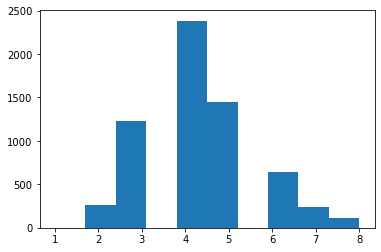

In [17]:
subset=junaeb.loc[junaeb['n_personas']<9] #se escoge un subconjunto de los datos con hasta 9 personas en el hogar
y=subset['n_personas']
X=subset[['vive_padre','vive_madre','cercania_juegos','cercania_servicios','n_habitaciones','edad_primer_parto','area','educm','educp']]
plt.hist(subset.n_personas)
subset.n_personas.head()

Del histograma se observa que la variable tiende a una distribución normal.

In [19]:
poisson=sm.GLM(y,X,family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             n_personas   No. Observations:                 6309
Model:                            GLM   Df Residuals:                     6300
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11394.
Date:                Thu, 15 Sep 2022   Deviance:                       1927.3
Time:                        12:37:41   Pearson chi2:                 2.08e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vive_padre             0.1191      0

In [20]:
print("fitted lambda")
print(poisson.mu) 

fitted lambda
[4.86806712 4.20885957 4.80387463 ... 3.29087039 3.85403004 4.14686457]


### Interpretación 

Luego de aplicar el modelo de Poisson para datos de conteo, se obtuvieron las siguientes variables significativas al 99% de confianza: vive_padre, vive_madre, cercania_juegos, cercania_servicios y n_habitaciones. Por lo que estas variables explican el número de personas que viven en el hogar. Además, la variable edad_primer_parto es significativa al 95% de confianza ya que su valor-p se encuentra entre 0,01 y 0,05. Por otro lado, tanto la educación del padre como la de la madre no son significativas, dado que su valor-p es mayor a 0.05, y por esto no aportan a explicar el numero de personas que viven en el hogar. 

Especificamente, la interpretación de las variables significativas es:
* El coeficiente de vive_padre implica que cuando los demás factores se mantienen iguales, aumenta el numero esperado de personas en el hogar en un 11,91% si el padre vive en el hogar. 
* El coeficiente de vive_madre implica que cuando los demás factores se mantienen iguales, aumenta el numero esperado de personas en el hogar en un 60,97% si la madre vive en el hogar.
* Si hay juegos cerca del hogar, el numero esperado de personas que viven en el hogar aumenta en un 8,27%.
* Si hay servicios de salud cerca de la vivienda, el numero esperado de personas que viven en el hogar aumenta 7,6%.
* Frente a un aumento de 1 habitación en el hogar, el logaritmo natural del numero de personas en el hogar aumenta en 0,1874 unidades.
* Mientras mayor es la edad en que la madre tiene a su primer hijo (aumento de 1 año), el logaritmo natural del numero de personas en el hogar disminuye en 0,0033 unidades. 
* Si la familia vive en una zona urbana, el numero esperado de personas que viven en el hogar aumenta en un 14,67%.

### Pregunta 7 y 8: Modelo Binomial Negativa

Se ejecuta un modelo Binomial Negativa para explicar el número de personas que hay dentro de un hogar (n_personas). Al igual que en el modelo Poisson se consideran todas las variables de la base de datos para realizar el modelo.

In [21]:
negbin=sm.GLM(y,X,family=sm.families.NegativeBinomial()).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             n_personas   No. Observations:                 6309
Model:                            GLM   Df Residuals:                     6300
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16225.
Date:                Thu, 15 Sep 2022   Deviance:                       371.09
Time:                        12:41:31   Pearson chi2:                     411.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
vive_padre             0.1270      0

In [22]:
print("fitted lambda")
print(negbin.mu)

fitted lambda
[4.95782241 4.22870311 4.84216442 ... 3.31470185 3.86390517 4.19959637]


### Test overdispersion

A simple test for overdispersion can be determined with the results of the Poisson model, using the ratio of Pearson chi2 / Df Residuals. A value larger than 1 indicates overdispersion. In the case above (6), data suggets overdispersion.

The Negative Binomial model estimated above is using a value of $\theta$ (or $\alpha=1/\theta$) equal to 1. In order to determine the appropiate value of $\alpha$, you can estimate a simple regression using the output of the Poisson model:

1. Construct the following variable aux=$[(y-\lambda)^2-\lambda]/\lambda$
2. Regress the variable aux with $\lambda$ as the only explanatory variable (no constant)
3. The estimated value is an appropiate guess for $\alpha=1/\theta$

In the model of the previous section, just use the options on sm.families.NegativeBinomial, in order to manually enter the value of alpha. See example below.

In [23]:
aux=((y-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.params)

x1   -0.153739
dtype: float64


### Pregunta 9: Poisson y Binomial Negativa

La obtención de un $\alpha$ negativo implica que la varianza es menor que la media, lo que significa que no hay sobredispersión de los datos, por lo que el modelo de Poisson genera una correcta estimación sobre estos. Si se aplicara un modelo Binomial Negativo no se obtendrían resultados correctos, ya que idealmente se necesitaría de un $\alpha$ mayor que 0, con una varianza mayor que la media.

<font size="3">**Tarea 1**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo el dia 14/9 hasta las 21:00. 
Además, es importante considerar que para que la revisión se pueda llevar a cabo, el código debe poder ejecutarse en cualquier computadora.

Las variables tienen la siguiente descripcion:

- vive_padre: si el padre vive en el hogar
- vive_madre: si la madre vive en el hogar
- n_personas: numero de integrantes del hogar
- n_habitaciones: numero de cuartos en el hogar
- cercania_juegos: hay juegos infantiles cerca de la vivienda (1=no, 2=si, 4=no sabe)
- cercania_servicios: hay serivicios de salud cerca de la vivienda (1=no, 2=si, 4=no sabe)
- edad_primer_parto: edad de la madre en su primer parto
- area: urbana=1, rural=0
- educm: años de escolaridad de la madre
- educp: años de escolaridad del padre

Preguntas:

1. Cargar la base de datos *junaeb.csv* en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que los padres se encuentren viviendo en el hogar (*vive_padre*). Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 
  
3. Ejecute un modelo *probit* que permita explicar la probabilidad de que los padres se encuentren viviendo en el hogar (*vive_padre*). Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

4. Ejecute un modelo *logit*  que permita explicar la probabilidad de que los padres se encuentren viviendo en el hogar(*vive_padre*). Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?
  
6. Ejecute un modelo Poisson para explicar el número de personas que hay dentro de un hogar. (*n_personas*). Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

7. Determine sobre dispersion y posible valor optimo de alpha para un modelo Binomial Negativa.

8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para explicar el número de personas que hay dentro de un hogar. (*n_personas*). Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 
  
9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?